# Weight Decay

If two input variables are very correlated, positively or negatively, and they have high-magnitude weights, they may have very little effect on the output of the model.  The sum of the products of their weights and values can be close to zero,

The magnitude of weights in a model is often used to indicate the relative importance of input variables, but in this case this would be very misleading.

Let's seet his with some example data.  Let's train a linear model to approximate

$$f(x_{i,1}) = 5 x_{i, 1}$$

for sample $i$, but include two additional variables in each sample, $x_{i, 2}$ and $x_{i, 3}$ that do not affect the value of $f(x_{i, 1})$ and that are highly correlated.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [440]:
X1 = np.random.uniform(-10, 10, (100, 1))
X2 = X1 # + np.random.normal(0, 0.001, (100, 1))
X3 = X1 # + np.random.normal(0, 0.0000000000001, (100, 1))
X4 = X1 # + np.random.normal(0, 0.00000000000015, (100, 1))
X5 = X1 # + np.random.normal(0, 0.0000000000001, (100, 1))
X6 = np.random.uniform(-10, 10, (100, 1))

T = 0.1 + 2 * X1 + 1 * X6

X = np.hstack((X1, X2, X3, X4, X5, X6))
X.shape, T.shape

((100, 6), (100, 1))

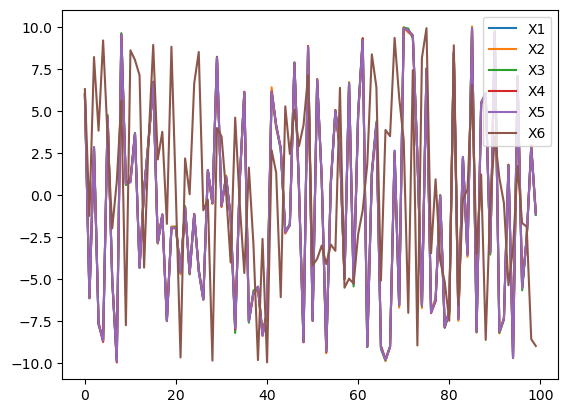

In [354]:
plt.plot(X)
plt.legend(('X1', 'X2', 'X3', 'X4', 'X5', 'X6'));

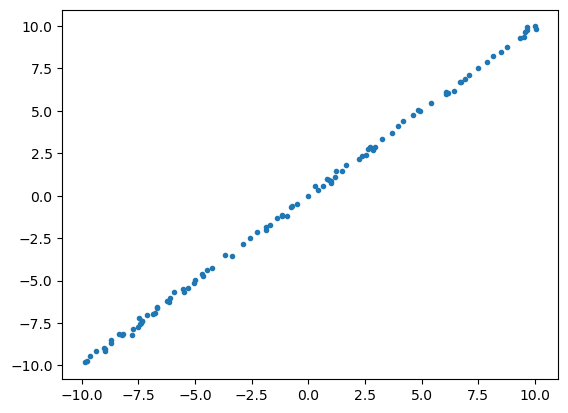

In [355]:
plt.plot(X2, X3, '.')

In [356]:
def linear_model(X, W):
    # W is column vector
    return X @ W[1:, :] + W[0, :]

def rmse(model, X, T, W):
    Y = model(X, W)
    return np.sqrt(np.mean((T - Y)**2))

def dYdW(X, T, W):
    # One row per sample in X,T.  One column per W component.
    # For first one, is constant 1.
    # For second one, is value of X
    return np.insert(X, 0, 1, axis=1)

def dEdY(X, T, W):
    Y = linear_model(X, W)
    return -2 * (T - Y)
    
def dEdW(X, T, W):
    result = dEdY(X, T, W).T @ dYdW(X, T, W) / (X.shape[0])
    return result.T

def gradient_descent(model_f, gradient_f, rmse_f, X, T, W, rho, nSteps):
    error_sequence = []
    W_sequence = []
    for step in range(nSteps):
        error_sequence.append(rmse_f(model_f, X, T, W))
        W_sequence.append(W.flatten())
        
        W -= rho * gradient_f(X, T, W)  # HERE IS THE WHOLE ALGORITHM!!
        
    return W, error_sequence, W_sequence

In [451]:
# W has four values, one for the bias (constant 1) input, and three for the three input variables

W = np.array([0, 100, 100, 0, 0, 0, 0]).reshape(-1, 1).astype(np.float64)  # try without the type cast
# W = np.array([100, 100, 100, 100, 100, 0, 0]).reshape(-1, 1).astype(np.float64)  # try without the type cast

nSteps = 20000
rho = 0.001

W, error_sequence, W_sequence = gradient_descent(linear_model, dEdW, rmse, X, T, W, rho, 0., nSteps)
print('Gradient Descent:  Error is {:.2f}   W is \n{}'.format(rmse(linear_model, X, T, W), W))

Gradient Descent:  Error is 0.00   W is 
[[  0.1]
 [ 60.4]
 [ 60.4]
 [-39.6]
 [-39.6]
 [-39.6]
 [  1. ]]


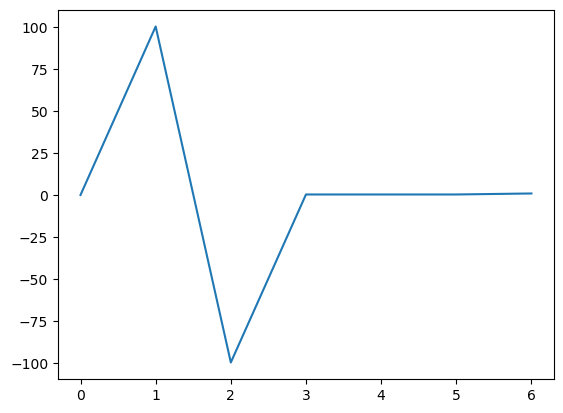

In [443]:
plt.plot(W)

In [359]:
def gradient_descent(model_f, gradient_f, rmse_f, X, T, W, rho, rho_decay, nSteps):
    error_sequence = []
    W_sequence = []
    for step in range(nSteps):
        error_sequence.append(rmse_f(model_f, X, T, W))
        W_sequence.append(W.flatten())
        W -= rho * (gradient_f(X, T, W) + rho_decay * W)  # HERE IS THE WHOLE ALGORITHM!!
        
        # for i in range(X.shape[0]):
        #     W -= rho * gradient_f(X[i:i+1, :], T[i:i+1,:], W) + rho_decay * W # HERE IS THE WHOLE ALGORITHM!!
        
    return W, error_sequence, W_sequence

In [366]:
# W has four values, one for the bias (constant 1) input, and three for the three input variables

W = np.array([0, 0, 0, 0, 0, 0, 0]).reshape(-1, 1).astype(np.float64)  # try without the type cast
# W = np.random.uniform(-5.0, 5.0, (7, 1))
nSteps = 200000
rho = 0.001
rho_decay = 0.5

W, error_sequence, W_sequence = gradient_descent(linear_model, dEdW, rmse, X, T, W, rho, rho_decay, nSteps)
print('Gradient Descent:  Error is {:.2f}   W is \n{}'.format(rmse(linear_model, X, T, W), W))

Gradient Descent:  Error is 0.06   W is 
[[0.08290552]
 [0.20288787]
 [0.19607079]
 [0.19707911]
 [0.20046023]
 [0.20315862]
 [0.99206544]]


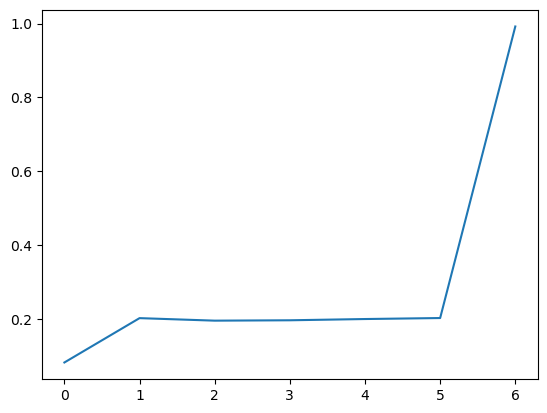

In [367]:
plt.plot(W)

## Claude

Here is what I get with the prompt

> Implement adamw in numpy without using pytorch

In [2]:
import numpy as np

def adamw(weights, gradients, lr, weight_decay, beta1=0.9, beta2=0.999, epsilon=1e-8):

    t = 0 # timestep
    m = np.zeros(weights.shape) # 1st moment
    v = np.zeros(weights.shape) # 2nd moment

    while True:
        t += 1
        lr_t = lr * np.sqrt(1 - beta2**t) / (1 - beta1**t) # lr decay

        m = beta1 * m + (1 - beta1) * gradients 
        v = beta2 * v + (1 - beta2) * (gradients**2)

        weight_decay_term = weight_decay * weights
        m_hat = m / (1 - beta1**t) 
        v_hat = v / (1 - beta2**t)

        weights -= lr_t * (m_hat + weight_decay_term) / (np.sqrt(v_hat) + epsilon)

        # Return weights for update
        yield weights
        
weights = np.array([1.0, 2.0])

opt = adamw(weights, gradients, lr=0.001, weight_decay=0.1)
for w in opt:
    # Update weights each step
    weights = w

NameError: name 'gradients' is not defined

With this follow on prompt:

> how is this different from adam

I see

<blockquote>
    The main difference between the Adam and AdamW optimizers is that AdamW includes a weight decay regularization term while Adam does not.

The key differences in the implementations are:

Adam:

Does not include a weight decay term in the update rule
The update rule is: weights = weights - lr * m_hat / (sqrt(v_hat) + epsilon)
AdamW:

Includes a weight decay term multiplied by the weights in the update rule
The update rule is: weights = weights - lr * (m_hat + weight_decay*weights) / (sqrt(v_hat) + epsilon)
So AdamW has the additional weight_decay*weights term added to the update rule.

Weight decay helps reduce overfitting by penalizing large weights and acts as a regularization method. This tends to improve generalization performance.

The weight decay term ends up shrinking the weights values over time, similar to L2 regularization.

So in summary:

Adam only uses the gradients to adapt the learning rate and update the weights
AdamW uses the gradients but also decays the weights directly each step via the weight decay term
AdamW provides the regularization benefits of weight decay which often improves results
That's the main difference - AdamW incorporates weight decay regularization into the optimization process.
    </blockquote>

This is somewhat misleading.  The article [Why AdamW matters](https://towardsdatascience.com/why-adamw-matters-736223f31b5d) by Fabio M. Graetz explains why a slightly different implentation of AdamW is better, using this algorithm specification:

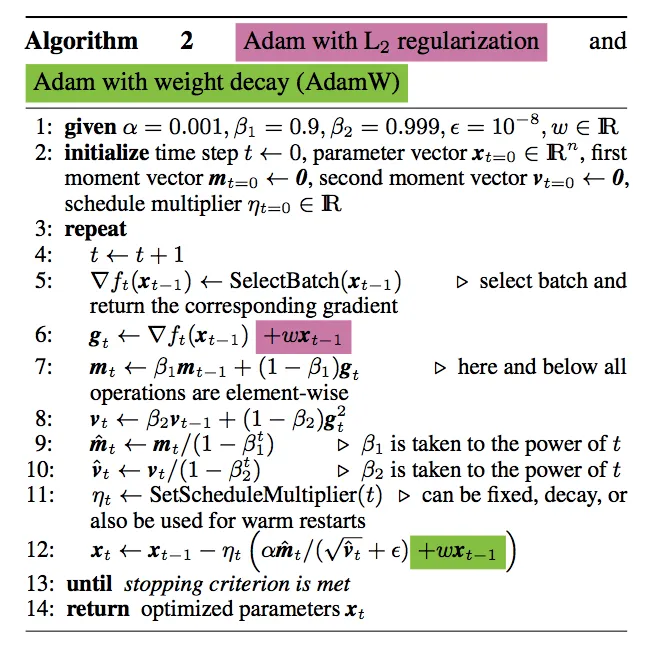

from [*Fixing Weight Decay Regularization in Adam*](https://arxiv.org/pdf/1711.05101v2.pdf), ICLR 2018, by I. Loshchilov and F. Hutter.

The Graetz article also cites [*Decoupled Weight Decay Regularization*](https://arxiv.org/abs/1711.05101), ICLR 2019, by Loshchilov and Hutter, that demonstrates the importance of correctly placing the weight decay term for AdamW.